# Introduction

# Cats vs Dogs Classification 🐱🐶

This project demonstrates how to build and fine-tune a Convolutional Neural Network (CNN) using **TensorFlow** and **Keras** to classify images of cats and dogs.  

We leverage **transfer learning** with the pre-trained **MobileNetV2** model (trained on ImageNet) and apply it to the **Cats vs Dogs dataset**.  

The workflow includes:
- Loading and preprocessing the dataset
- Using transfer learning with MobileNetV2
- Training with frozen layers (feature extraction) and fine-tuning
- Evaluating model performance (accuracy, confusion matrix, classification report)
- Saving trained models and artifacts

This project is designed as a portfolio-friendly example of computer vision applied to binary classification tasks.


# Import Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np, itertools
from PIL import Image

from sklearn.metrics import confusion_matrix, classification_report
from google.colab import files


# Load Cats vs Dogs Dataset

In [2]:
(ds_train, ds_val), ds_info = tfds.load(
    "cats_vs_dogs",
    split=["train[:80%]", "train[80%:]"],
    as_supervised=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.C5XZI6_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [3]:
ds_info

tfds.core.DatasetInfo(
    name='cats_vs_dogs',
    full_name='cats_vs_dogs/4.0.1',
    description="""
    A large set of images of cats and dogs. There are 1738 corrupted images that are dropped.
    """,
    homepage='https://www.microsoft.com/en-us/download/details.aspx?id=54765',
    data_dir='/root/tensorflow_datasets/cats_vs_dogs/4.0.1',
    file_format=tfrecord,
    download_size=786.67 MiB,
    dataset_size=1.04 GiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=23262, num_shards=16>,
    },
    citation="""@Inproceedings (Conference){asirra-a-captcha-that-exploits-interest-aligned-manual-image-categorization,
    author = {Elson, Jeremy and Douceur, Jo

# Preprocess Data (fixing broken images + resize)

In [4]:
IMG_SIZE = 160

def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

ds_train = ds_train.map(preprocess).shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


# Build Model (Transfer Learning)

In [5]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights="imagenet"
)
base_model.trainable = False  # Freeze pretrained layers

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_160            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

# Train Model

In [6]:
history = model.fit(ds_train, validation_data=ds_val, epochs=5)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 79s 102ms/step - accuracy: 0.9276 - loss: 0.1716 - val_accuracy: 0.9757 - val_loss: 0.0663
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 45s 63ms/step - accuracy: 0.9798 - loss: 0.0586 - val_accuracy: 0.9781 - val_loss: 0.0606
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 37s 57ms/step - accuracy: 0.9821 - loss: 0.0524 - val_accuracy: 0.9802 - val_loss: 0.0581
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 34s 57ms/step - accuracy: 0.9845 - loss: 0.0480 - val_accuracy: 0.9794 - val_loss: 0.0589
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 38s 63ms/step - accuracy: 0.9852 - loss: 0.0452 - val_accuracy: 0.9802 - val_loss: 0.0570


# Fine-tune (unfreezing some layers)

In [8]:
base_model.trainable = True
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),  # lower LR
              loss="binary_crossentropy",
              metrics=["accuracy"])

history_fine = model.fit(ds_train, validation_data=ds_val, epochs=3)


Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 135s 137ms/step - accuracy: 0.9143 - loss: 0.2043 - val_accuracy: 0.9807 - val_loss: 0.0657
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.9705 - loss: 0.0754 - val_accuracy: 0.9804 - val_loss: 0.0571
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 50s 84ms/step - accuracy: 0.9793 - loss: 0.0542 - val_accuracy: 0.9796 - val_loss: 0.0545


# Test On The New Image

In [9]:
# Function to show random test image
def test_random_image():
    # Take 1 random example from validation dataset
    for image, label in ds_val.shuffle(1000).take(1):
        plt.imshow(image[0].numpy())
        plt.axis("off")
        pred = model.predict(image[0:1], verbose=0)

        # Prediction result
        predicted_class = "Dog 🐶" if pred[0][0] > 0.5 else "Cat 🐱"
        true_class = "Dog 🐶" if label[0].numpy() == 1 else "Cat 🐱"

        print(f"Prediction: {predicted_class}")
        print(f"True label: {true_class}")

        plt.show()

Prediction: Dog 🐶
True label: Dog 🐶


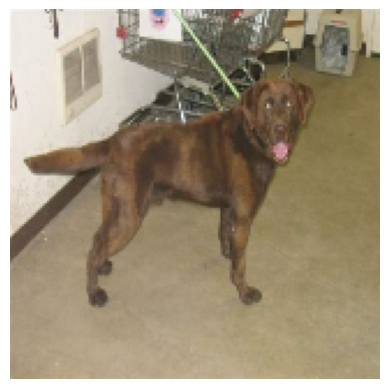

In [11]:
# Run the test function
test_random_image()

# Evaluation and Metrics

Accuracy & loss on the whole val set

In [12]:
val_loss, val_acc = model.evaluate(ds_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f} | Validation Loss: {val_loss:.4f}")

Validation Accuracy: 0.9796 | Validation Loss: 0.0545


Confusion matrix & classification report

              precision    recall  f1-score   support

         Cat       0.98      0.97      0.98      2280
         Dog       0.97      0.99      0.98      2372

    accuracy                           0.98      4652
   macro avg       0.98      0.98      0.98      4652
weighted avg       0.98      0.98      0.98      4652



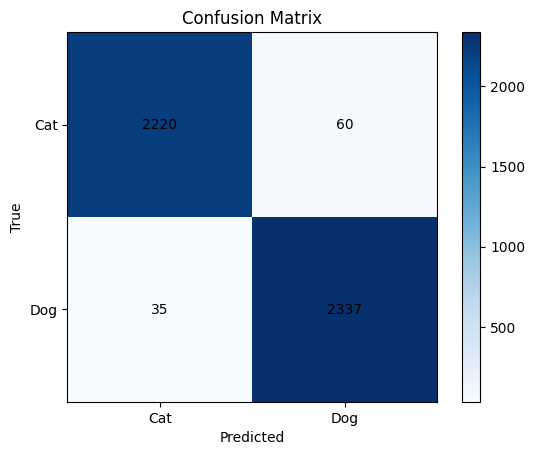

In [13]:
# collect all preds/labels
y_true, y_pred = [], []
for images, labels in ds_val:
    probs = model.predict(images, verbose=0).ravel()
    preds = (probs >= 0.5).astype(int)
    y_pred.extend(preds.tolist())
    y_true.extend(labels.numpy().astype(int).tolist())

cm = confusion_matrix(y_true, y_pred, labels=[0,1])  # 0=Cat, 1=Dog
print(classification_report(y_true, y_pred, target_names=["Cat","Dog"]))

# plot confusion matrix
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix'); plt.colorbar()
ticks = np.arange(2)
plt.xticks(ticks, ['Cat','Dog']); plt.yticks(ticks, ['Cat','Dog'])
for i, j in itertools.product(range(2), range(2)):
    plt.text(j, i, cm[i, j], ha="center", va="center")
plt.xlabel('Predicted'); plt.ylabel('True')
plt.show()


Learning curves (from history and history_fine)

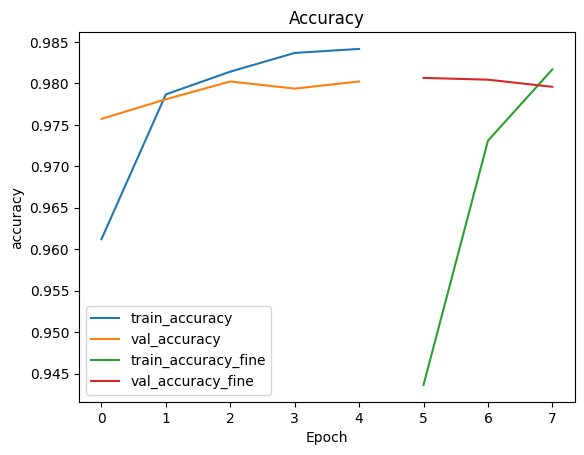

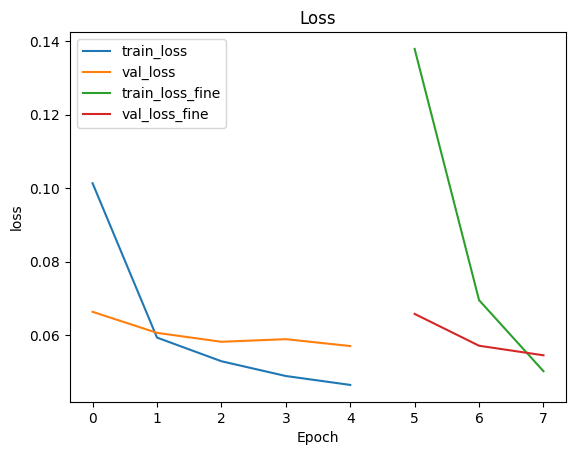

In [14]:
def plot_curves(h1, h2=None, metric='accuracy'):
    plt.figure()
    plt.plot(h1.history[metric], label=f'train_{metric}')
    plt.plot(h1.history[f'val_{metric}'], label=f'val_{metric}')
    if h2:
        plt.plot(range(len(h1.history[metric]), len(h1.history[metric])+len(h2.history[metric])),
                 h2.history[metric], label=f'train_{metric}_fine')
        plt.plot(range(len(h1.history[metric]), len(h1.history[metric])+len(h2.history[metric])),
                 h2.history[f'val_{metric}'], label=f'val_{metric}_fine')
    plt.legend(); plt.title(metric.capitalize()); plt.xlabel('Epoch'); plt.ylabel(metric)
    plt.show()

plot_curves(history, history_fine, metric='accuracy')
plot_curves(history, history_fine, metric='loss')


# Conclusion

We successfully trained a **deep learning model** to distinguish between cats and dogs.  
Key takeaways:
- Pre-trained models like **MobileNetV2** help achieve high accuracy with limited compute resources.  
- Preprocessing steps (resizing, normalization, batching) are essential for stable training.  
- Fine-tuning improves performance beyond feature extraction by updating some pre-trained weights.  
- Evaluation with metrics (accuracy, precision, recall, F1-score) provides a more complete picture than accuracy alone.  

This project demonstrates the **end-to-end process** of:
1. Data preparation  
2. Model building and training  
3. Evaluation and visualization  
4. Saving models and artifacts for reproducibility  

Such workflows can be adapted to other **binary or multi-class image classification problems** by changing the dataset and adjusting hyperparameters.


# Save Model

In [15]:
model.save('cats_vs_dogs_mobilenetv2.keras')